In [1]:
#1
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import requests
from pathlib import Path
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from MCForecastTools import MCSimulation


In [2]:
#2
# Import API data
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

In [3]:
#3
# Load .env enviroment variables
load_dotenv("ProjectAPI.env")

True

In [4]:
#4
# Set the tickers
tickers = ["SPY", "IWM", "EZU", "EWU", "EWJ", "EWZ", "EWA", "EWC", "MCHI", "EWW"]

# Create the shares DataFrame
df_etf = pd.DataFrame(index=tickers)

In [5]:
#5
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("Alpaca_API_Key")
alpaca_secret_key = os.getenv("Alpaca_Secret_Key")

# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [6]:
#6
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [7]:
#6a
# Create current date variable
import datetime
today = datetime.date.today()
historical = today - datetime.timedelta(days=550)

In [8]:
#6b
# Format current date as ISO format
# Set start and end datetimes of 18 months
start_date = pd.Timestamp(historical, tz="America/New_York").isoformat()
end_date = pd.Timestamp(today, tz="America/New_York").isoformat()

In [9]:
#7
# Set timeframe to 18 months for the Alpaca API
timeframe = "1Day"

In [10]:
#8
# Get 18 months of pricing data for ETF portfolio
df_portfolio = alpaca.get_bars(tickers, timeframe, start=start_date, end=end_date).df

df_portfolio

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2022-07-01 04:00:00+00:00,21.0900,21.110,20.710,14348,20.83,4894055,20.931355,EWA
2022-07-05 04:00:00+00:00,20.8200,20.820,20.485,14187,20.60,6139665,20.610715,EWA
2022-07-06 04:00:00+00:00,20.9700,21.005,20.715,11324,20.94,5204745,20.861028,EWA
2022-07-07 04:00:00+00:00,21.4100,21.410,21.250,14752,21.25,4091099,21.356667,EWA
2022-07-08 04:00:00+00:00,21.3200,21.450,21.170,10922,21.28,5662409,21.338199,EWA
...,...,...,...,...,...,...,...,...
2023-12-26 05:00:00+00:00,475.6500,476.580,473.990,348986,474.07,55386952,475.111253,SPY
2023-12-27 05:00:00+00:00,476.5100,476.660,474.890,425538,475.44,68000811,475.770446,SPY
2023-12-28 05:00:00+00:00,476.6900,477.550,476.260,374241,476.88,77158117,476.774686,SPY


In [11]:
#9
# Drop unnecessary columns for our portfolio dataframe
df_portfolio.drop(columns=['high','low','open', 'volume', 'trade_count','vwap'], axis=1, inplace=True)

#Rearrange columns
df_portfolio = df_portfolio[['symbol', 'close']]

df_portfolio

,symbol,close
timestamp,,
2022-07-01 04:00:00+00:00,EWA,21.0900
2022-07-05 04:00:00+00:00,EWA,20.8200
2022-07-06 04:00:00+00:00,EWA,20.9700
2022-07-07 04:00:00+00:00,EWA,21.4100
2022-07-08 04:00:00+00:00,EWA,21.3200
...,...,...
2023-12-26 05:00:00+00:00,SPY,475.6500
2023-12-27 05:00:00+00:00,SPY,476.5100
2023-12-28 05:00:00+00:00,SPY,476.6900


In [12]:
#10
# Reorganize the DataFrame and separate ticker data
# Order:  SPY, EWA, EWC, EWJ, EWU, EWZ, EWW, EZU, IWM, MCHI

# Separate ticker data
SPY = df_portfolio[df_portfolio["symbol"]=="SPY"].drop("symbol", axis=1)
EWA = df_portfolio[df_portfolio["symbol"]=="EWA"].drop("symbol", axis=1)
EWC = df_portfolio[df_portfolio["symbol"]=="EWC"].drop("symbol", axis=1)
EWJ = df_portfolio[df_portfolio["symbol"]=="EWJ"].drop("symbol", axis=1)
EWU = df_portfolio[df_portfolio["symbol"]=="EWU"].drop("symbol", axis=1)
EWZ = df_portfolio[df_portfolio["symbol"]=="EWZ"].drop("symbol", axis=1)
EWW = df_portfolio[df_portfolio["symbol"]=="EWW"].drop("symbol", axis=1)
EZU = df_portfolio[df_portfolio["symbol"]=="EZU"].drop("symbol", axis=1)
IWM = df_portfolio[df_portfolio["symbol"]=="IWM"].drop("symbol", axis=1)
MCHI = df_portfolio[df_portfolio["symbol"]=="MCHI"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_portreo = pd.concat([SPY, EWA, EWC, EWJ, EWU, EWZ, EWW, EZU, IWM, MCHI], axis=1)

# Rename columns
df_portreo.columns=['SPY_close', 'EWA_close', 'EWC_close', 'EWJ_close', 'EWU_close', 'EWZ_close', 'EWW_close', 'EZU_close', 'IWM_close', 'MCHI_close']

# Display sample data
df_portreo

,SPY_close,EWA_close,EWC_close,EWJ_close,EWU_close,EWZ_close,EWW_close,EZU_close,IWM_close,MCHI_close
timestamp,,,,,,,,,,
2022-07-01 04:00:00+00:00,381.2400,21.09,34.04,53.050,29.89,27.07,46.460,36.430,171.41,55.830
2022-07-05 04:00:00+00:00,381.9600,20.82,33.20,52.710,29.01,26.43,45.680,35.140,172.83,55.620
2022-07-06 04:00:00+00:00,383.2500,20.97,33.02,52.700,29.14,26.37,45.660,35.070,171.55,54.790
2022-07-07 04:00:00+00:00,388.9900,21.41,33.76,53.450,29.60,27.31,45.550,35.650,175.61,56.020
2022-07-08 04:00:00+00:00,388.6700,21.32,33.75,53.720,29.49,27.54,45.960,35.750,175.59,55.520
...,...,...,...,...,...,...,...,...,...,...
2023-12-26 05:00:00+00:00,475.6500,24.44,36.83,63.310,33.09,35.15,68.310,47.570,204.10,39.570
2023-12-27 05:00:00+00:00,476.5100,24.56,36.87,63.660,33.22,35.27,68.460,47.810,204.82,39.530
2023-12-28 05:00:00+00:00,476.6900,24.49,36.70,64.040,33.05,35.11,67.960,47.410,204.04,40.460


In [13]:
#11
# Simplifying the data frame for Monte Carlo simulation
SPY_mc = pd.concat([SPY,EWA], axis=1, keys=['SPY','EWA'])

SPY_mc

,SPY,EWA
,close,close
timestamp,,
2022-07-01 04:00:00+00:00,381.2400,21.09
2022-07-05 04:00:00+00:00,381.9600,20.82
2022-07-06 04:00:00+00:00,383.2500,20.97
2022-07-07 04:00:00+00:00,388.9900,21.41
2022-07-08 04:00:00+00:00,388.6700,21.32
...,...,...
2023-12-26 05:00:00+00:00,475.6500,24.44
2023-12-27 05:00:00+00:00,476.5100,24.56


In [14]:
#12
# Export clean dataframe to .csv file for backup

df_portreo.to_csv(r'UpDownFlatData.csv')

In [15]:
#13
# Create the Monte Carlo Simulation for the next day
MC_df = SPY_mc[["SPY"]]

monte_predict = MCSimulation(
    portfolio_data = MC_df,
    num_simulation = 1000,
    num_trading_days = 1
)

#Check it worked
monte_predict.portfolio_data.head()

SPY             
                            close daily_return
timestamp                                     
2022-07-01 04:00:00+00:00  381.24          NaN
2022-07-05 04:00:00+00:00  381.96     0.001889
2022-07-06 04:00:00+00:00  383.25     0.003377
2022-07-07 04:00:00+00:00  388.99     0.014977
2022-07-08 04:00:00+00:00  388.67    -0.000823

In [16]:
#14
# Run a Monte Carlo simulation to forecast tomorrow's movement
from MCForecastTools import MCSimulation

monte_predict.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.986602,0.996258,1.014025,1.004143,1.012369,1.006795,1.005256,1.014558,1.002029,1.010067,...,1.006583,0.993549,1.004673,1.006168,1.003718,0.994653,1.019948,0.998512,0.986164,0.999332


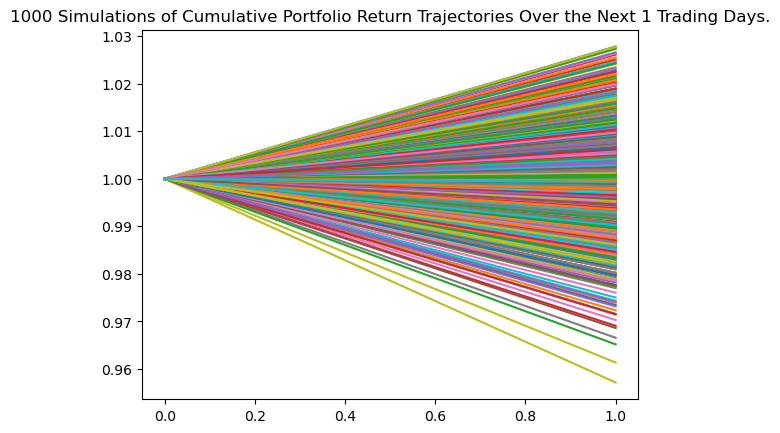

In [17]:
#14.a
line_plot1 = monte_predict.plot_simulation()

In [18]:
#15
# Show what the prediction average and std are to give an idea of tomorrow's likelyhood of up/down
MC_tbl = monte_predict.summarize_cumulative_return()
MC_tbl

count           1000.000000
mean               1.000173
std                0.010993
min                0.957137
25%                0.992582
50%                0.999825
75%                1.007369
max                1.027851
95% CI Lower       0.978517
95% CI Upper       1.020923
Name: 1, dtype: float64

In [19]:
#16
# Based on the table output, display the mean, low, and high of the target outcomes.
yest_close = df_portreo['SPY_close'][-1]
MC_avg = (yest_close)*(MC_tbl['mean'])
if MC_avg >= yest_close:
    MC_low = (yest_close)*(MC_tbl['25%'])
    MC_high = (yest_close)*(MC_tbl['75%'])
else:
    MC_low = (yest_close)*(MC_tbl['75%'])
    MC_high = (yest_close)*(MC_tbl['25%'])

# Display predictions
print(f"Yesterday's close: {yest_close}\n Monte Carlo Prediction middle: {round(MC_avg,2)}\n Low: {round(MC_low,2)}\n High: {round(MC_high,2)}")

Yesterday's close: 472.5898
 Monte Carlo Prediction middle: 472.67
 Low: 469.08
 High: 476.07


In [20]:
#17
# Define variables for regression

X=df_portreo[['EWA_close', 'EWC_close', 'EWJ_close', 'EWU_close', 'EWZ_close', 'EWW_close', 'EZU_close', 'IWM_close', 'MCHI_close']]

y=df_portreo['SPY_close']

In [21]:
#18
# Set up test and train section of the df
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = None)

In [22]:
#19
# Test regression model to understand fit and accuracy
reg = LinearRegression()
 
# Fit the model to the data
reg_model = LinearRegression().fit(X_train, y_train)


# Print the coefficients of the model to determine influences on X
coeffs = reg_model.coef_
cols = ['EWA_close', 'EWC_close', 'EWJ_close', 'EWU_close', 'EWZ_close', 'EWW_close', 'EZU_close', 'IWM_close', 'MCHI_close']
count = 0
for t in coeffs:
    display(f'{cols[count]} beta is {coeffs[count],}')
    count +=1
display(f"Intercept is {round(reg_model.intercept_, 4)}")

'EWA_close beta is (-8.824620239672086,)'

'EWC_close beta is (6.391228447759171,)'

'EWJ_close beta is (5.529980608121932,)'

'EWU_close beta is (-3.977989726926289,)'

'EWZ_close beta is (1.7319219884115313,)'

'EWW_close beta is (-1.9853375857316395,)'

'EZU_close beta is (4.321659496680861,)'

'IWM_close beta is (0.6130005701497891,)'

'MCHI_close beta is (-0.7337198654194148,)'

'Intercept is 0.2078'

In [23]:
#19.a
# Set up predicted close dates for the last two days
Yt = (reg_model.intercept_ + 
    (df_portreo['EWA_close'][-1] * coeffs[0]) + 
    (df_portreo['EWC_close'][-1] * coeffs[1]) + 
    (df_portreo['EWJ_close'][-1] * coeffs[2]) + 
    (df_portreo['EWU_close'][-1] * coeffs[3]) + 
    (df_portreo['EWZ_close'][-1] * coeffs[4]) + 
    (df_portreo['EWW_close'][-1] * coeffs[5]) + 
    (df_portreo['EZU_close'][-1] * coeffs[6]) + 
    (df_portreo['IWM_close'][-1] * coeffs[7]) + 
    (df_portreo['MCHI_close'][-1] * coeffs[8])
    )

Yt

461.6012863141763

In [24]:
Yy = (reg_model.intercept_ + 
    (df_portreo['EWA_close'][-2] * coeffs[0]) + 
    (df_portreo['EWC_close'][-2] * coeffs[1]) + 
    (df_portreo['EWJ_close'][-2] * coeffs[2]) + 
    (df_portreo['EWU_close'][-2] * coeffs[3]) + 
    (df_portreo['EWZ_close'][-2] * coeffs[4]) + 
    (df_portreo['EWW_close'][-2] * coeffs[5]) + 
    (df_portreo['EZU_close'][-2] * coeffs[6]) + 
    (df_portreo['IWM_close'][-2] * coeffs[7]) + 
    (df_portreo['MCHI_close'][-2] * coeffs[8])
    )

Yy

467.0731737392166

<Axes: xlabel='timestamp'>

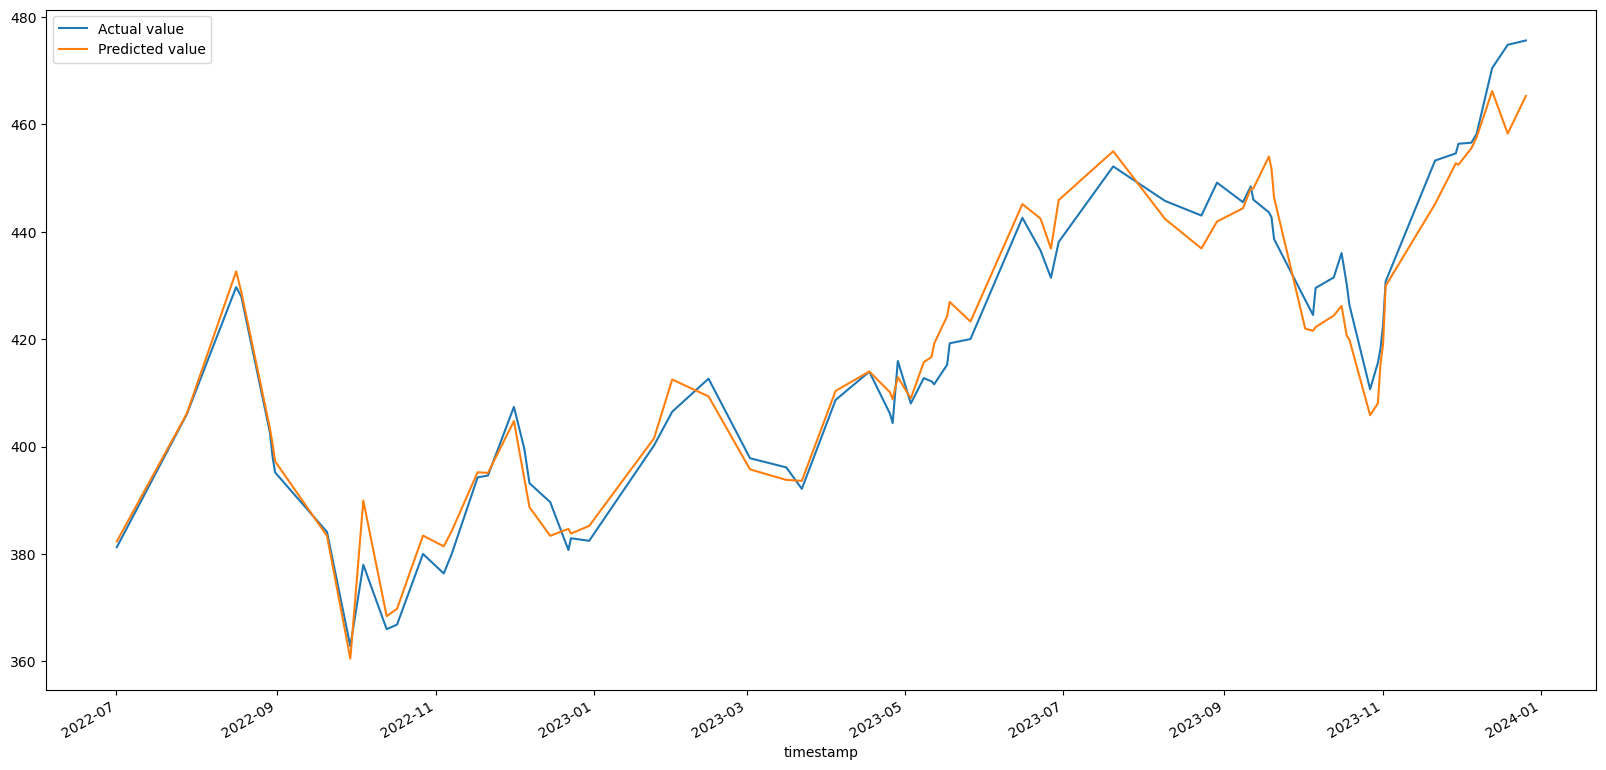

In [25]:
#20
# Setting up the Test and Train set result 

y_pred= reg_model.predict(X_test)  
x_pred= reg_model.predict(X_train)

# Finding the difference between predicted and actual values- for reference of predictive accuracy of model
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
reg_model_diff.plot(figsize=(20,10))

In [26]:
#20.a
# Display the score (accuracy) of model
reg_model.score(X,y)
print(f"Accuracy of model is {round(reg_model.score(X,y),4)*100}%")

Accuracy of model is 95.88%


In [27]:
#21 
# Regression prediction and outcome


In [37]:
#22
# Overall prediction variables and logic
reg_change = Yt-Yy
mc_change = MC_avg-yest_close

if reg_change > 2 and mc_change > 2:
    overall = 'Up'
elif (-2) <= reg_change <= 2 and  (-2) <= mc_change <= 2:
    overall = 'Flat'
else:
    overall = 'Down'



In [ ]:
#23
# Initiate GUI interface
import tkinter as tk 
#from tkinter import ttk
import ttkbootstrap as ttk
import tkmacosx
#from tkmacosx import Button
from tkinter import Button, Message, font
def convert():
    

    prediction_output = f'Monte Carlo Prediction\n\nLast Close: {round(yest_close, 2)}\nAverage: {round(MC_avg, 2)}\nLow: {round(MC_low, 2)}\nHigh: {round(MC_high, 2)}\n\nRegression Prediction: {round(reg_change, 2)}\n\nOverall Likely Prediction: {overall}'
    
    output_string.set(prediction_output)

# window 
window = tk.Tk()
window.title ('Up/Down/Flat')
window.geometry('500x500')
#title 
title_label =ttk.Label(master=window, text = 'SPY ON TOMORROW',font = 'calibri 30 bold')
title_label.pack()
# input field 
input_frame = ttk.Frame(master = window)
title_label2 =ttk.Label(master=input_frame, text = f'SPY Next Day Prediction Tool\n',font = 'calibri 20 bold')
title_label2.pack()
#entry_int = tk.IntVar()
#entry = ttk.Entry(master =input_frame, textvariable = entry_int)
button = ttk.Button(master = input_frame,text = 'Predict Next Day ', command = convert)

button.pack(side = 'top')
input_frame.pack(pady = 10)

# output 
output_string = tk.StringVar()
output_label = ttk.Label(
    master = window,
    text = 'Output',
    font = 'Calibri 16', 
    textvariable = output_string)
output_label.pack(pady = 5)
# run
window.mainloop()